In [ ]:
# ! conda install swig

In [189]:
import os
import numpy as np
from pathlib import Path
from pprint import pprint
import itertools
import pandas as pd
import seaborn as sns
import datetime

import Box2D

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
from torch.distributions import normal

import gym
from gym.wrappers import Monitor
from gym.spaces import Box, Discrete

# from pyvirtualdisplay import Display
# from IPython import display as ipythondisplay
# from IPython.display import clear_output
# import base64



######################## Import internal modules 

import utils

## Setup the environment
See https://github.com/openai/gym/wiki/Leaderboard for description of OpenAIGym environments

Discrete control settings : 
* "Taxi-v3" : episodic & discrete setting both for states and actions (S/N/E/W/Pickup/Dropoff)
* __"CartPole-v0" / "CartPole-v1" : discrete action and continuous state space__
* __"MountainCar-v0" : discrete action and continuous state space__

Continous control settings :
* __"MountainCarContinuous-v0" (both state and action continuous spaces)__
* "LunarLanderContinuous-v2" (requires box2D)
* "CarRacing-v0" : "Discrete control is reasonable in this environment as well" (requires box2D)

* "MsPacman-v0 "(requires the Atari dependency)

Settings used by the authors (requires the MuJoCo dependencies, 30 days free trial) : https://github.com/openai/mujoco-py
* "HalfCheetah-v1" (use v2 now?)
* "Hopper-v1"
* etc.

## Configuration 

In [370]:
config = {}
config['env'] = 'CartPole-v1'
# config['env'] = 'MountainCarContinuous-v0'
# config['env'] = 'LunarLander-v2'
# config['env'] = 'MountainCar-v0'

# config['std'] = 0.5 # use constant standard deviation for continuous action space (for now)
config['std'] = 0.001 # use constant standard deviation for continuous action space (for now)
config['gamma'] = 0.99 #Discount rate
config['lambda'] = 1 # parameter of the generalized advantage estimation
config['value_network'] = {'lr': 1e-3}
config['actor_network'] = {'lr': 1e-3}
config['eps_clipping'] = 0.2
config['d_targ'] = 0.01
config['beta_KL'] = 3
config['c1'] = 1 #paramter of the value function loss
config['c2'] = 1e-3 #entropy parameter
# config['epochs'] = 10
# config['batch_size'] = 10
config['loss_name'] = ["A2C_loss","adaptative_KL_loss","clipped_loss"][2]

config['seed'] = 1

print("Training config : \n", config)

Training config : 
 {'env': 'CartPole-v1', 'std': 0.001, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'loss_name': 'clipped_loss', 'seed': 1}


In [371]:
## Define environment 
env = gym.make(config['env'])

## Save episode
# env = Monitor(env, "./gym-results", force=True)

## Action and state spaces
print("State Space : {}".format(env.observation_space))
if isinstance(env.observation_space, Box) :
    print("continuous state space") 
    print("Lower bound : ", env.observation_space.low)
    print("Upper bound : ", env.observation_space.high)
else :
    print("discrete state space")

print("\nAction Space : {}".format(env.action_space))
if isinstance(env.action_space, Box):
    print("continuous action space") 
    print("Lower bound : ", env.action_space.low)
    print("Uppder bound : ", env.action_space.high)
else :
    print("discrete action space")

print("\nReward range", env.reward_range)
    
## Reset the environment
env.reset()
print("\nInitial state : ",env.state)
env = env.env
# env.render()

## Sample randomly one action
action = env.action_space.sample()
print("Sampled action : " , action)
try :
    state, reward, done, info = env.step(a = action)
except :
    state, reward, done, info = env.step(action = action)
# env.render()
print("\nEpisode over : ",done)

State Space : Box(4,)
continuous state space
Lower bound :  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Upper bound :  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]

Action Space : Discrete(2)
discrete action space

Reward range (-inf, inf)

Initial state :  [ 0.04912534  0.00941853 -0.0426945   0.00456192]
Sampled action :  0

Episode over :  False


## Actor and critic networks 


Questions : __/!\ not defined precisely in the paper ??__

NB : no parameter sharing between policy and value function

In [372]:
class CustomValueNetwork(nn.Module):
    """
    Approximation of the value function V of a state given as input
    FC network with 1 hidden layer and ReLU activations
    Class used as 'critic'
    Inputs : 
    input_size : dimension of each state
    hidden_size : number of hidden layers
    output_size : 1 (dimension of the value function estimate)
    """

    def __init__(self, input_size, hidden_size, output_size = 1):
        super(CustomValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x.float()))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).detach().numpy()[0]

In [374]:
# test 
critic = CustomValueNetwork(env.observation_space.shape[0], 16, 1)
critic(torch.tensor(env.state))

tensor([0.2362], grad_fn=<AddBackward0>)

In [375]:
class CustomDiscreteActorNetwork(nn.Module):
    """
    Custom policy model network for discrete action space
    Inputs : 
    input_size : state space dimension
    hidden_size : nb of hidden layers (64 in author's paper for continous action space)
    action_size : action space dimension
    """
    def __init__(self, input_size, hidden_size, action_size):
        super(CustomDiscreteActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

__Questions :__
* gaussian distribution for bounded actions ? 
* set std parameter 

In [376]:
class ContinuousActorNetwork(nn.Module):
    """
    Policy model network for continuous action space (from the paper)
    Inputs : 
    input_size : state space dimension
    hidden_size : nb of hidden layers used by the authors
    action_size : action space dimension
    """
    def __init__(self, input_size, hidden_size, action_size, std, env):
        super(ContinuousActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        self.std = std
        self.env = env
        
    def forward(self, x):
        out = torch.tanh(self.fc1(x.float()))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        return out
    
    def select_action(self, x):
        print(x)
        sampled_a = torch.normal(self(x), self.std).detach().numpy()
        print("sampled a",sampled_a)
        sampled_a = max(self.env.action_space.low, sampled_a)
        print(sampled_a)
        sampled_a = min(self.env.action_space.high, sampled_a)
#         print(sampled_a)
        return sampled_a


In [377]:
# test
if isinstance(env.action_space, Discrete) : #check if we are in a discrete action space
    actor = CustomDiscreteActorNetwork(env.observation_space.shape[0], 64, env.action_space.n)
else :
    actor = ContinuousActorNetwork(env.observation_space.shape[0], 64, env.action_space.shape[0], config["std"], env)

print("Mean : ", actor(torch.tensor(env.state)))
print("Sampled action : ", actor.select_action(torch.tensor(env.state)))

Mean :  tensor([0.5070, 0.4930], grad_fn=<SoftmaxBackward>)
Sampled action :  [0]


TODO :
__Problème dans la clipped loss??__
- rajouter un truc pour normale tronquée ? --> à la fois dans les réseaux et dans les dans les fonctions... 
- vérifier le produit scalaire qui prend directement les actions (gather) pour clipped --> problème dans la loss ? 
-  vérifier les histoires de log proba, etc.
__Then__
- define adaptative loss in discrete + continuous case
- check entropy definition
- modify constant std (in config, =1 for now)
- ( modify advantage definition --> ok)

TODO later :
- modify class to take into account different types of nets, optimizers
- add early stopping
- look at default values in paper/..

NB : issue graph nb of epochs

In [399]:
class PPOAgent:

    def __init__(self, config):
        ## configuration
        self.config = config
        
        ## define environment
        self.env = gym.make(config['env'])
        self.discrete_action_bool = isinstance(env.action_space, Discrete)
        self.gamma = config['gamma'] #discount rate
        self.lambd = config['lambda'] #parameter of the generalized advantage estimation
        self.c1 = config['c1'] # value function hyperparameter
        self.c2 = config['c2'] # entropy bonus hyperparameter (eventually set to 0)
        self.loss_name = config['loss_name'] # loss in ["A2C_loss","adaptative_KL_loss","clipped_loss"]
        self.kl_div = nn.KLDivLoss(reduction="none")
        self.beta_kl = config['beta_KL']
        self.break_bool = False #make sure the actions are properly defined (no NaN)
        
        ## set random seeds
        np.random.seed(config['seed'])
        torch.manual_seed(config['seed'])
        self.env.seed(config['seed'])
        
#         # save trajectory
#         self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        
        
        ## Define actor and critic networks and optimizers
        # Critic
        self.value_network = CustomValueNetwork(self.env.observation_space.shape[0], 16, 1)
        self.value_network_optimizer: optim.Optimizer = optim.RMSprop(
            self.value_network.parameters(), lr=config['value_network']['lr'])
        
        # Actor     
        if self.discrete_action_bool : #check if we are in a discrete action space
            self.actor_network = CustomDiscreteActorNetwork(self.env.observation_space.shape[0], 64, self.env.action_space.n)
        else :
            self.actor_network = ContinuousActorNetwork(self.env.observation_space.shape[0], 64, self.env.action_space.shape[0], self.config["std"], self.env)
        self.actor_network_optimizer: optim.Optimizer = optim.RMSprop(
            self.actor_network.parameters(), lr=config['actor_network']['lr'])
        
        # save in memory policy estimates
        self.probs_list = []
        self.mean_list = []
        
    def _returns_advantages(self, rewards, dones, values, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network
        
        Returns
        -------
        returns : array
            The cumulative discounted rewards
        advantages : array
            The advantages
        """
#         returns = np.empty_like(rewards)
        returns = 0*rewards
        
        R = next_value
        for i in range(1, len(rewards)+1):
            retro_prop = 1-dones[-i]  # whether to use the following value
            R = rewards[-i] + (self.lambd*self.gamma * retro_prop * R)
            returns[-i] = R
        
#         advantages = returns - values
        advantages = returns - values
        return returns, advantages

    def training_batch(self, epochs, batch_size):
        t1 = datetime.datetime.now()
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        env = self.env
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        obs = self.env.reset()
        rewards_test = []
        if self.loss_name not in ["A2C_loss","adaptative_KL_loss","clipped_loss"]:
            print('Unknown loss function, using clipped loss as default loss')
        else :
            print('Loss : ',self.loss_name)
        
        for epoch in range(epochs):
            assert self.break_bool == False
            # Lets collect one batch
            for i in range(batch_size):
                observations[i] = obs  # just observed s_t
                obs_t = torch.from_numpy(obs).float()  # tensor
                action = self.actor_network.select_action(obs_t)  # act on just observed, action a_t
                
                if self.discrete_action_bool : #convert to integer only for discrete action space
                    action = int(action)
                    actions[i] = int(action)
                else : ##++to modify ??
                    try :
                        it = 0
                        while ((action < env.action_space.low) | (action > env.action_space.high)) & (it<1000) :
                            action = self.actor_network.select_action(obs_t)
                            it += 1
                        if it == 1000 : 
                            print("maximum iteration reached when sampling actions")
                            self.break_bool = True
                        else :
                            assert (action >= env.action_space.low) & (action <= env.action_space.high)
                            actions[i] = action
                        
                    except :
                        print("issue with selected action : ",action)
                        self.break_bool = True
                
                # value function estimate of s_t
                values[i] = self.value_network(obs_t) 
                
                ## Run a step : get new state s_{t+1} and rewards r_t
                obs, reward, done, _ = self.env.step(action) 
                
                # Store termination status reward
                dones[i]   = done
                rewards[i] = reward
                
                # reset the environment if last observation is the a terminal state
                if dones[i]:
                    obs = env.reset()

            # If our episode didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0  # no value function adjustment
            else:
                obs_t = torch.from_numpy(observations[-1]).float()
                next_value = self.value_network.predict(obs_t)
            
            # Update episode_count
            episode_count += sum(dones)

            # Compute returns and advantages
            returns, advantages = self._returns_advantages(rewards, dones, values, next_value)

            # Learning step !
            self.optimize_model(observations, actions, returns, dones, advantages)
            
            
            # Test it every 50 epochs
            if epoch == 10 or (epoch > 0 and epoch % 25 == 0) or epoch == epochs - 1:
                rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
                print(f'Epoch {epoch}/{epochs}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

#                 #+++ Early stopping ++ to add --> which condition ??
            
            obs = self.env.reset()
        
        env.close()
        t2 = datetime.datetime.now()
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
        print(f'The training was done over a total of {episode_count} episodes')
        print('Total time ellapsed during training : ',t2-t1)
        
    def A2C_loss(self, prob, actions, advantages):
        loss = 0.
        if self.discrete_action_bool :
            for i in range(len(actions)):
                loss -= torch.log(prob[i, actions[i]])*advantages[i]
#             loss = - torch.dot(prob.gather(1, torch.tensor(actions).long().view(-1,1)).view(-1),advantages)
        else :
#             print(type(prob))
#             print(prob.view(-1).shape)
            loss = torch.dot(torch.log(prob.view(-1)),advantages)
#             for i in range(len(actions)):
#                 m = normal.Normal(loc = prob[i].float(), scale = torch.tensor(config["std"]).float())
#                 loss -= m.log_prob(torch.tensor(actions[i]).float())*advantages[i]          
        return loss
    
    def compute_proba_ratio(self, prob, actions):
        #1st iteration : initialize old policy to the current one to avoid clipping
        if len(self.probs_list) == 1:
            old_prob = self.probs_list[0]
        else :
            old_prob = self.probs_list[len(self.probs_list)-2]
            
        # Discrete action space
        if self.discrete_action_bool :
#             ratio_vect = torch.tensor(actions*0).float()
#             for i in range(len(actions)):
#                 num = prob[i, int(actions[i])]
#                 denom = old_prob[i, int(actions[i])].detach()
#                 ratio_vect[i] = num/denom
# #                 print("compar",num[i]," ",denom[i]," ",num[i]/denom[i], " ", ratio_vect[i])
 
            # compute the ratio directly using gather function
            num = prob.gather(1, torch.tensor(actions).long().view(-1,1))
            denom = old_prob.detach().gather(1, torch.tensor(actions).long().view(-1,1))
            ratio_vect = num.view(-1)/denom.view(-1)
        
        # Continuous action space
        else :##+++ add small constant to avoid ratio explosion ? consider clipping enough ?? 
            ratio_vect = prob.view(-1)/old_prob.view(-1)
        
        return ratio_vect, old_prob
    
    def clipped_loss(self, prob, actions, advantages):##++TODO
        ##Compute the probability ratio
        ratio_vect = self.compute_proba_ratio(prob, actions)[0]
#         ratio_vect = torch.tensor(ratio_vect).float()
        ## Compute the loss
        loss1 = ratio_vect * advantages
        loss2 = torch.clamp(ratio_vect, 1-self.config['eps_clipping'], 1+self.config['eps_clipping']) * advantages
        loss = - torch.sum(torch.min(loss1, loss2)) 
#         print(loss) #toremove
        return loss

    def adaptative_KL_loss(self, prob, actions, advantages, observations):
#         if self.discrete_action_bool == False : #toremove
#             print("--------Number of iterations---------",len(self.mean_list)) #toremove
            
        ## Compute the loss
        if self.discrete_action_bool :
            ##Compute the probability ratio
            ratio_vect, old_prob = self.compute_proba_ratio(prob, actions)
            kl = self.kl_div(prob[observations.long(),:], old_prob[observations.long(),:])
            kl = kl.view(prob.size()[0],-1).mean(1)
        else :
            ratio_vect = self.compute_proba_ratio(prob, actions)[0]
            if len(self.mean_list) == 1:
                kl = torch.tensor(0.)
            else :
                mu = prob.view(-1)
                mu_old = self.mean_list[len(self.mean_list)-2].view(-1).detach()
                # use KL formula for gaussian 
                kl = torch.dot((mu-mu_old)/torch.tensor(config["std"]*np.ones(len(actions))).float(),mu-mu_old)/2
#                 print("-------------------kl",kl) #remove
                
        loss = - torch.sum((ratio_vect*advantages) - (self.beta_kl*kl))
#         print("loss",loss) #toremove
        # Update beta values
        if torch.mean(kl) < self.config["d_targ"]/1.5 : 
            self.beta_kl = self.beta_kl / 2
        elif torch.mean(kl) > self.config["d_targ"]*1.5 :
            self.beta_kl = self.beta_kl * 2
        return loss
    
    
        
    def optimize_model(self, observations, actions, returns, dones, advantages):
        
        n_trajs = np.sum(dones)
        
        returns = torch.from_numpy(returns[:, None]).float()
        advantages = torch.from_numpy(advantages).float()
        observations = torch.from_numpy(observations).float()  # shape (batch_size,)
        
        # Critic loss
        net_values: torch.Tensor = self.value_network(observations)
        critic_loss = F.mse_loss(net_values, returns)
        critic_loss.backward()
        
        self.value_network_optimizer.step()
        
        # Actor & Entropy loss
        #/!\ doesn't have the same meaning in the discrete and continuous case
        prob: torch.Tensor = self.actor_network(observations)  # shape (batch_size,action_space)
            
        if self.discrete_action_bool == True :
            self.probs_list.append(prob.detach())
        else :#there
            m = normal.Normal(loc = prob.view(-1).float(), scale = torch.tensor(config["std"]*np.ones(len(actions))).float())
            logprob = m.log_prob(torch.tensor(actions).float())
            # /!\ to add for truncated version :
#             logprob_bound = m.log_prob(torch.tensor(self.env.action_space.high))
#             self.probs_list.append(torch.max(torch.zeros_like(logprob),torch.exp(logprob).detach()-torch.exp(logprob_bound).detach()))
            # /!\ non truncated version :
            self.probs_list.append(torch.exp(logprob).detach())
            self.mean_list.append(prob)
        
        if not dones[-1]:
            n_trajs += 1
        
        if self.loss_name == "clipped_loss":
            loss = self.clipped_loss(prob, actions, advantages)

        elif self.loss_name == "adaptative_KL_loss":
            loss = self.adaptative_KL_loss(prob, actions, advantages, observations)
            
        elif self.loss_name == "A2C_loss":
            loss = self.A2C_loss(prob, actions, advantages)
            
        else :#use clipped loss as default
            loss = self.clipped_loss(prob, actions, advantages)
            
            
        
        entropy_term = self.c2 * torch.sum(prob * torch.log(prob))
#         print("entrop",entropy_term)
        loss += entropy_term
        loss = loss / n_trajs
        
        loss.backward()
        
        self.actor_network_optimizer.step()
        
        self.value_network_optimizer.zero_grad()
        self.actor_network_optimizer.zero_grad()

        return loss.detach().numpy()

    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        observation = torch.from_numpy(observation).float()
        reward_episode = 0
        done = False
        with torch.no_grad():
            while not done:
                policy = self.actor_network(observation)
                
                ##++ question : why not only sample action ?? 
                if self.discrete_action_bool : 
                    action = int(torch.multinomial(policy, 1))  # draw an action
                else :
                    action_defined = False 
                    while action_defined == False :      
#                         action = torch.normal(policy.float(), torch.tensor(config["std"]*np.ones(len(policy))).float())
                        action = self.actor_network.select_action(observation)
                        action_defined = (action >= self.env.action_space.low) & (action <= self.env.action_space.high)
                observation, reward, done, info = env.step(action)
                observation = torch.from_numpy(observation).float()
                reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

{'env': 'CartPole-v1', 'std': 0.5, 'gamma': 0.99, 'lambda': 1, 'value_network': {'lr': 0.001}, 'actor_network': {'lr': 0.001}, 'eps_clipping': 0.2, 'd_targ': 0.01, 'beta_KL': 3, 'c1': 1, 'c2': 0.001, 'loss_name': 'adaptative_KL_loss', 'seed': 1}
Loss :  adaptative_KL_loss
Epoch 10/100: Mean rewards: 44.54, Std: 15.38
Epoch 25/100: Mean rewards: 26.44, Std: 4.66
Epoch 50/100: Mean rewards: 60.58, Std: 31.81
Epoch 75/100: Mean rewards: 36.48, Std: 8.27
Epoch 99/100: Mean rewards: 22.54, Std: 4.06
The training was done over a total of 51 episodes
Total time ellapsed during training :  0:00:06.913691


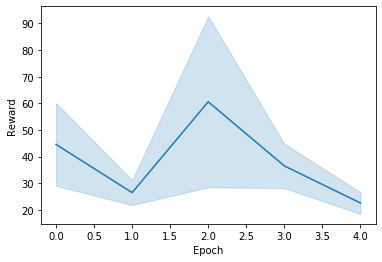

In [388]:
config["eps_clipping"] = 0.2
config["std"] = 0.5
# config["loss_name"]="clipped_loss"
config["loss_name"]="adaptative_KL_loss"
# config["loss_name"]="A2C_loss"
print(config)
agent = PPOAgent(config)
EPOCHS = 100
BATCH_SIZE = 30
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

Loss :  clipped_loss
Epoch 10/1000: Mean rewards: 23.62, Std: 9.88
Epoch 25/1000: Mean rewards: 28.7, Std: 13.52
Epoch 50/1000: Mean rewards: 31.84, Std: 23.23
Epoch 75/1000: Mean rewards: 36.92, Std: 20.79
Epoch 100/1000: Mean rewards: 40.02, Std: 23.39
Epoch 125/1000: Mean rewards: 38.26, Std: 25.33
Epoch 150/1000: Mean rewards: 30.22, Std: 21.26
Epoch 175/1000: Mean rewards: 31.7, Std: 22.06
Epoch 200/1000: Mean rewards: 34.16, Std: 21.79
Epoch 225/1000: Mean rewards: 27.66, Std: 15.95
Epoch 250/1000: Mean rewards: 37.42, Std: 27.95
Epoch 275/1000: Mean rewards: 31.74, Std: 20.04
Epoch 300/1000: Mean rewards: 38.02, Std: 28.26
Epoch 325/1000: Mean rewards: 32.82, Std: 21.89
Epoch 350/1000: Mean rewards: 33.06, Std: 26.27
Epoch 375/1000: Mean rewards: 40.98, Std: 28.47
Epoch 400/1000: Mean rewards: 32.24, Std: 20.59
Epoch 425/1000: Mean rewards: 33.44, Std: 19.94
Epoch 450/1000: Mean rewards: 33.34, Std: 19.4
Epoch 475/1000: Mean rewards: 33.58, Std: 21.35
Epoch 500/1000: Mean reward

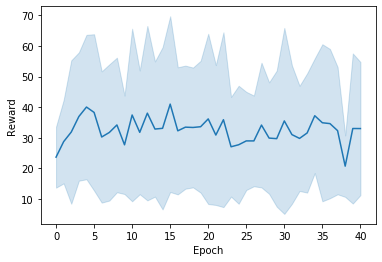

In [400]:
config["eps_clipping"] = 0.2
config["std"] = 0.5
config["loss_name"]="clipped_loss"
agent = PPOAgent(config)
EPOCHS = 1000
BATCH_SIZE = 1000
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

Loss :  clipped_loss
Epoch 10/1000: Mean rewards: 30.52, Std: 15.9
Epoch 25/1000: Mean rewards: 35.94, Std: 19.59
Epoch 50/1000: Mean rewards: 34.28, Std: 22.25
Epoch 75/1000: Mean rewards: 33.98, Std: 22.94
Epoch 100/1000: Mean rewards: 33.92, Std: 20.09
Epoch 125/1000: Mean rewards: 31.42, Std: 15.2
Epoch 150/1000: Mean rewards: 31.22, Std: 16.16
Epoch 175/1000: Mean rewards: 23.48, Std: 13.17
Epoch 200/1000: Mean rewards: 27.24, Std: 15.23
Epoch 225/1000: Mean rewards: 26.56, Std: 19.53
Epoch 250/1000: Mean rewards: 31.48, Std: 17.89
Epoch 275/1000: Mean rewards: 29.12, Std: 15.58
Epoch 300/1000: Mean rewards: 28.24, Std: 18.42
Epoch 325/1000: Mean rewards: 32.24, Std: 17.22
Epoch 350/1000: Mean rewards: 35.38, Std: 22.03
Epoch 375/1000: Mean rewards: 36.48, Std: 23.34
Epoch 400/1000: Mean rewards: 27.96, Std: 15.47
Epoch 425/1000: Mean rewards: 32.12, Std: 22.25
Epoch 450/1000: Mean rewards: 37.86, Std: 31.56
Epoch 475/1000: Mean rewards: 32.98, Std: 21.73
Epoch 500/1000: Mean rewa

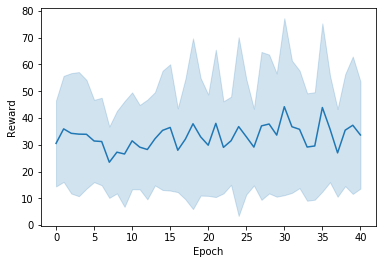

In [390]:
config["eps_clipping"] = 0.2
config["std"] = 0.5
config["loss_name"]="clipped_loss"
agent = PPOAgent(config)
EPOCHS = 1000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

In [ ]:
config["eps_clipping"] = 0.2
config["std"] = 0.5
config["loss_name"]="clipped_loss"
agent = PPOAgent(config)
EPOCHS = 1000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

Loss :  adaptative_KL_loss
Epoch 10/1000: Mean rewards: 55.96, Std: 17.28
Epoch 25/1000: Mean rewards: 51.18, Std: 25.98
Epoch 50/1000: Mean rewards: 40.22, Std: 13.08
Epoch 75/1000: Mean rewards: 41.88, Std: 18.67
Epoch 100/1000: Mean rewards: 50.36, Std: 15.98
Epoch 125/1000: Mean rewards: 24.22, Std: 3.88
Epoch 150/1000: Mean rewards: 38.58, Std: 11.81
Epoch 175/1000: Mean rewards: 24.98, Std: 3.87
Epoch 200/1000: Mean rewards: 23.82, Std: 3.93
Epoch 225/1000: Mean rewards: 24.0, Std: 3.93
Epoch 250/1000: Mean rewards: 21.78, Std: 3.78
Epoch 275/1000: Mean rewards: 21.76, Std: 3.96
Epoch 300/1000: Mean rewards: 22.4, Std: 3.77
Epoch 325/1000: Mean rewards: 22.2, Std: 4.15
Epoch 350/1000: Mean rewards: 22.64, Std: 4.42
Epoch 375/1000: Mean rewards: 20.26, Std: 3.6
Epoch 400/1000: Mean rewards: 21.5, Std: 3.91
Epoch 425/1000: Mean rewards: 21.14, Std: 3.66
Epoch 450/1000: Mean rewards: 18.1, Std: 2.86
Epoch 475/1000: Mean rewards: 18.12, Std: 2.34
Epoch 500/1000: Mean rewards: 19.2, S

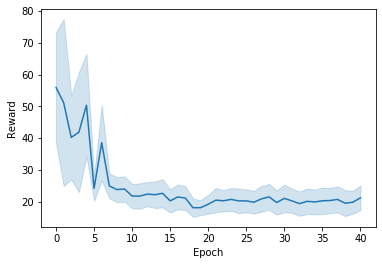

In [392]:
config["std"] = 0.5
config["loss_name"]="adaptative_KL_loss"
agent = PPOAgent(config)
EPOCHS = 1000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

Loss :  A2C_loss
Epoch 10/1000: Mean rewards: 33.34, Std: 8.96
Epoch 25/1000: Mean rewards: 66.02, Std: 25.82
Epoch 50/1000: Mean rewards: 93.02, Std: 18.0
Epoch 75/1000: Mean rewards: 146.24, Std: 16.81
Epoch 100/1000: Mean rewards: 167.48, Std: 52.97
Epoch 125/1000: Mean rewards: 185.4, Std: 17.43
Epoch 150/1000: Mean rewards: 209.9, Std: 13.92
Epoch 175/1000: Mean rewards: 183.38, Std: 13.98
Epoch 200/1000: Mean rewards: 320.24, Std: 26.27
Epoch 225/1000: Mean rewards: 414.5, Std: 38.7
Epoch 250/1000: Mean rewards: 492.94, Std: 35.27
Epoch 275/1000: Mean rewards: 500.0, Std: 0.0
Epoch 300/1000: Mean rewards: 179.54, Std: 8.28
Epoch 325/1000: Mean rewards: 196.1, Std: 10.94
Epoch 350/1000: Mean rewards: 319.54, Std: 22.71
Epoch 375/1000: Mean rewards: 187.16, Std: 23.27
Epoch 400/1000: Mean rewards: 160.82, Std: 8.94
Epoch 425/1000: Mean rewards: 216.38, Std: 16.05
Epoch 450/1000: Mean rewards: 495.38, Std: 32.34
Epoch 475/1000: Mean rewards: 280.86, Std: 16.48
Epoch 500/1000: Mean r

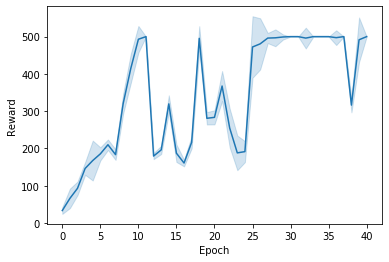

In [393]:
config["std"] = 0.5
config["loss_name"]="A2C_loss"
agent = PPOAgent(config)
EPOCHS = 1000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

Loss :  adaptative_KL_loss
Epoch 10/10000: Mean rewards: 55.96, Std: 17.28
Epoch 25/10000: Mean rewards: 51.18, Std: 25.98
Epoch 50/10000: Mean rewards: 40.22, Std: 13.08
Epoch 75/10000: Mean rewards: 41.88, Std: 18.67
Epoch 100/10000: Mean rewards: 50.36, Std: 15.98
Epoch 125/10000: Mean rewards: 24.22, Std: 3.88
Epoch 150/10000: Mean rewards: 38.58, Std: 11.81
Epoch 175/10000: Mean rewards: 24.98, Std: 3.87
Epoch 200/10000: Mean rewards: 23.82, Std: 3.93
Epoch 225/10000: Mean rewards: 24.0, Std: 3.93
Epoch 250/10000: Mean rewards: 21.78, Std: 3.78
Epoch 275/10000: Mean rewards: 21.76, Std: 3.96
Epoch 300/10000: Mean rewards: 22.4, Std: 3.77
Epoch 325/10000: Mean rewards: 22.2, Std: 4.15
Epoch 350/10000: Mean rewards: 22.64, Std: 4.42
Epoch 375/10000: Mean rewards: 20.26, Std: 3.6
Epoch 400/10000: Mean rewards: 21.5, Std: 3.91
Epoch 425/10000: Mean rewards: 21.14, Std: 3.66
Epoch 450/10000: Mean rewards: 18.1, Std: 2.86
Epoch 475/10000: Mean rewards: 18.12, Std: 2.34
Epoch 500/10000: 

Epoch 4200/10000: Mean rewards: 47.18, Std: 13.24
Epoch 4225/10000: Mean rewards: 43.32, Std: 13.21
Epoch 4250/10000: Mean rewards: 46.52, Std: 14.92
Epoch 4275/10000: Mean rewards: 45.16, Std: 14.37
Epoch 4300/10000: Mean rewards: 53.54, Std: 23.2
Epoch 4325/10000: Mean rewards: 44.26, Std: 17.28
Epoch 4350/10000: Mean rewards: 43.96, Std: 17.29
Epoch 4375/10000: Mean rewards: 48.28, Std: 18.38
Epoch 4400/10000: Mean rewards: 47.88, Std: 22.19
Epoch 4425/10000: Mean rewards: 45.28, Std: 16.05
Epoch 4450/10000: Mean rewards: 41.7, Std: 11.81
Epoch 4475/10000: Mean rewards: 44.58, Std: 15.6
Epoch 4500/10000: Mean rewards: 43.04, Std: 13.45
Epoch 4525/10000: Mean rewards: 44.9, Std: 15.95
Epoch 4550/10000: Mean rewards: 40.48, Std: 17.27
Epoch 4575/10000: Mean rewards: 46.54, Std: 15.82
Epoch 4600/10000: Mean rewards: 52.86, Std: 19.27
Epoch 4625/10000: Mean rewards: 50.54, Std: 21.04
Epoch 4650/10000: Mean rewards: 47.72, Std: 14.97
Epoch 4675/10000: Mean rewards: 60.34, Std: 26.03
Epoc

Epoch 8325/10000: Mean rewards: 40.46, Std: 12.69
Epoch 8350/10000: Mean rewards: 39.92, Std: 13.41
Epoch 8375/10000: Mean rewards: 42.56, Std: 14.18
Epoch 8400/10000: Mean rewards: 39.68, Std: 13.38
Epoch 8425/10000: Mean rewards: 39.72, Std: 14.12
Epoch 8450/10000: Mean rewards: 38.84, Std: 14.44
Epoch 8475/10000: Mean rewards: 41.92, Std: 17.92
Epoch 8500/10000: Mean rewards: 43.02, Std: 16.56
Epoch 8525/10000: Mean rewards: 39.9, Std: 16.43
Epoch 8550/10000: Mean rewards: 42.3, Std: 17.41
Epoch 8575/10000: Mean rewards: 39.94, Std: 15.4
Epoch 8600/10000: Mean rewards: 39.86, Std: 12.96
Epoch 8625/10000: Mean rewards: 40.24, Std: 15.09
Epoch 8650/10000: Mean rewards: 39.64, Std: 13.68
Epoch 8675/10000: Mean rewards: 40.5, Std: 15.7
Epoch 8700/10000: Mean rewards: 40.72, Std: 15.22
Epoch 8725/10000: Mean rewards: 39.42, Std: 13.59
Epoch 8750/10000: Mean rewards: 40.22, Std: 14.93
Epoch 8775/10000: Mean rewards: 40.56, Std: 13.95
Epoch 8800/10000: Mean rewards: 39.78, Std: 13.94
Epoch

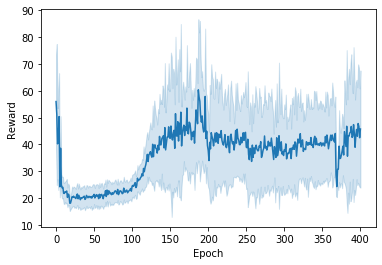

In [247]:
config["eps_clipping"] = 0.2
agent = PPOAgent(config)
EPOCHS = 10000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

### Discrete action env

### Clipped loss

Epoch 10/50: Mean rewards: 57.56, Std: 27.11
Epoch 25/50: Mean rewards: 29.14, Std: 9.93
Epoch 49/50: Mean rewards: 26.62, Std: 16.25
The training was done over a total of 19 episodes
Total time ellapsed during training :  0:00:04.136454


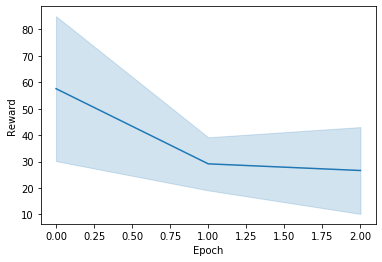

In [56]:
config["eps_clipping"] = 0.2
agent = PPOAgent(config)
EPOCHS = 50
BATCH_SIZE = 30
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

Epoch 10/1000: Mean rewards: 30.52, Std: 15.9
Epoch 25/1000: Mean rewards: 35.94, Std: 19.59
Epoch 50/1000: Mean rewards: 34.28, Std: 22.25
Epoch 75/1000: Mean rewards: 33.98, Std: 22.94
Epoch 100/1000: Mean rewards: 33.92, Std: 20.09
Epoch 125/1000: Mean rewards: 31.42, Std: 15.2
Epoch 150/1000: Mean rewards: 31.22, Std: 16.16
Epoch 175/1000: Mean rewards: 23.48, Std: 13.17
Epoch 200/1000: Mean rewards: 27.24, Std: 15.23
Epoch 225/1000: Mean rewards: 26.56, Std: 19.53
Epoch 250/1000: Mean rewards: 31.48, Std: 17.89
Epoch 275/1000: Mean rewards: 29.12, Std: 15.58
Epoch 300/1000: Mean rewards: 28.24, Std: 18.42
Epoch 325/1000: Mean rewards: 32.24, Std: 17.22
Epoch 350/1000: Mean rewards: 35.38, Std: 22.03
Epoch 375/1000: Mean rewards: 36.48, Std: 23.34
Epoch 400/1000: Mean rewards: 27.96, Std: 15.47
Epoch 425/1000: Mean rewards: 32.12, Std: 22.25
Epoch 450/1000: Mean rewards: 37.86, Std: 31.56
Epoch 475/1000: Mean rewards: 32.98, Std: 21.73
Epoch 500/1000: Mean rewards: 29.84, Std: 18.7

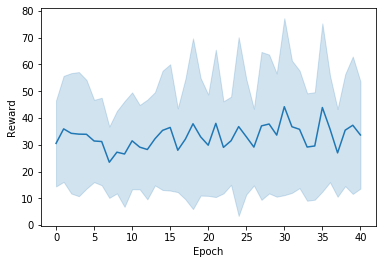

In [57]:
config["eps_clipping"] = 0.2
agent = PPOAgent(config)
EPOCHS = 1000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

Epoch 10/1000: Mean rewards: 39.94, Std: 21.5
Epoch 25/1000: Mean rewards: 43.78, Std: 28.75
Epoch 50/1000: Mean rewards: 79.38, Std: 45.44
Epoch 75/1000: Mean rewards: 53.24, Std: 28.4
Epoch 100/1000: Mean rewards: 56.68, Std: 45.0
Epoch 125/1000: Mean rewards: 59.36, Std: 34.54
Epoch 150/1000: Mean rewards: 66.68, Std: 49.35
Epoch 175/1000: Mean rewards: 71.9, Std: 43.02
Epoch 200/1000: Mean rewards: 40.28, Std: 19.15
Epoch 225/1000: Mean rewards: 33.2, Std: 17.23
Epoch 250/1000: Mean rewards: 30.14, Std: 16.46
Epoch 275/1000: Mean rewards: 33.04, Std: 21.48
Epoch 300/1000: Mean rewards: 32.04, Std: 22.29
Epoch 325/1000: Mean rewards: 52.7, Std: 41.21
Epoch 350/1000: Mean rewards: 38.6, Std: 24.68
Epoch 375/1000: Mean rewards: 35.18, Std: 22.12
Epoch 400/1000: Mean rewards: 37.24, Std: 24.76
Epoch 425/1000: Mean rewards: 33.36, Std: 22.6
Epoch 450/1000: Mean rewards: 36.76, Std: 23.83
Epoch 475/1000: Mean rewards: 37.96, Std: 26.74
Epoch 500/1000: Mean rewards: 35.96, Std: 29.13
Epoc

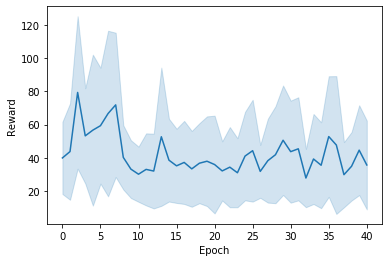

In [59]:
config["eps_clipping"] = 0.3
agent = PPOAgent(config)
EPOCHS = 1000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

In [ ]:
# discrete env
config["eps_clipping"] = 0.4
agent = PPOAgent(config)
EPOCHS = 1000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

Epoch 10/1000: Mean rewards: 43.88, Std: 17.98
Epoch 25/1000: Mean rewards: 88.18, Std: 24.41
Epoch 50/1000: Mean rewards: 82.62, Std: 31.27
Epoch 75/1000: Mean rewards: 271.24, Std: 83.91
Epoch 100/1000: Mean rewards: 134.34, Std: 12.2
Epoch 125/1000: Mean rewards: 356.68, Std: 76.29
Epoch 150/1000: Mean rewards: 258.06, Std: 65.97
Epoch 175/1000: Mean rewards: 349.02, Std: 74.4
Epoch 200/1000: Mean rewards: 403.12, Std: 85.59
Epoch 225/1000: Mean rewards: 316.36, Std: 81.11
Epoch 250/1000: Mean rewards: 296.36, Std: 73.55
Epoch 275/1000: Mean rewards: 272.82, Std: 70.39
Epoch 300/1000: Mean rewards: 295.42, Std: 77.33
Epoch 325/1000: Mean rewards: 300.96, Std: 80.57
Epoch 350/1000: Mean rewards: 286.74, Std: 87.59
Epoch 375/1000: Mean rewards: 250.92, Std: 83.82
Epoch 400/1000: Mean rewards: 257.98, Std: 96.53
Epoch 425/1000: Mean rewards: 195.94, Std: 93.26
Epoch 450/1000: Mean rewards: 132.68, Std: 62.05
Epoch 475/1000: Mean rewards: 61.04, Std: 27.03
Epoch 500/1000: Mean rewards: 

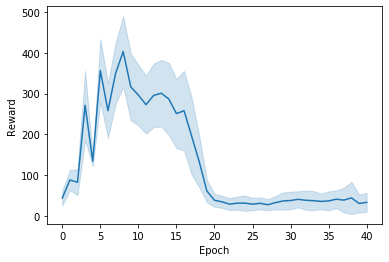

In [60]:
# discrete env
config["eps_clipping"] = 0.4
agent = PPOAgent(config)
EPOCHS = 1000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

Epoch 10/1000: Mean rewards: 24.88, Std: 6.89
Epoch 25/1000: Mean rewards: 33.52, Std: 10.4
Epoch 50/1000: Mean rewards: 119.34, Std: 16.5
Epoch 75/1000: Mean rewards: 254.38, Std: 72.94
Epoch 100/1000: Mean rewards: 45.02, Std: 7.54
Epoch 125/1000: Mean rewards: 9.5, Std: 0.73
Epoch 150/1000: Mean rewards: 9.42, Std: 0.72
Epoch 175/1000: Mean rewards: 9.4, Std: 0.57
Epoch 200/1000: Mean rewards: 9.38, Std: 0.72
Epoch 225/1000: Mean rewards: 9.28, Std: 0.85
Epoch 250/1000: Mean rewards: 9.42, Std: 0.75
Epoch 275/1000: Mean rewards: 9.3, Std: 0.73
Epoch 300/1000: Mean rewards: 9.48, Std: 0.7
Epoch 325/1000: Mean rewards: 9.28, Std: 0.63
Epoch 350/1000: Mean rewards: 9.32, Std: 0.68
Epoch 375/1000: Mean rewards: 9.6, Std: 0.66
Epoch 400/1000: Mean rewards: 9.34, Std: 0.82
Epoch 425/1000: Mean rewards: 9.36, Std: 0.71
Epoch 450/1000: Mean rewards: 9.34, Std: 0.84
Epoch 475/1000: Mean rewards: 9.08, Std: 0.74
Epoch 500/1000: Mean rewards: 9.2, Std: 0.8
Epoch 525/1000: Mean rewards: 9.24, S

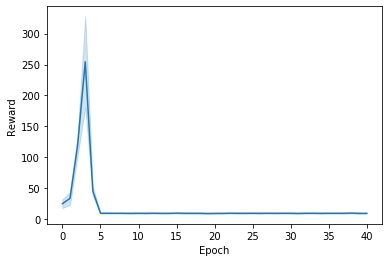

In [45]:
# eps_clipping = 0.5

agent = PPOAgent(config)
EPOCHS = 1000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)

### A2C loss

Loss :  A2C_loss 


Epoch 10/1000: Mean rewards: 33.34, Std: 8.96
Epoch 25/1000: Mean rewards: 66.02, Std: 25.82
Epoch 50/1000: Mean rewards: 93.02, Std: 18.0
Epoch 75/1000: Mean rewards: 146.24, Std: 16.81
Epoch 100/1000: Mean rewards: 167.48, Std: 52.97
Epoch 125/1000: Mean rewards: 185.4, Std: 17.43
Epoch 150/1000: Mean rewards: 209.9, Std: 13.92
Epoch 175/1000: Mean rewards: 183.38, Std: 13.98
Epoch 200/1000: Mean rewards: 320.24, Std: 26.27
Epoch 225/1000: Mean rewards: 414.5, Std: 38.7
Epoch 250/1000: Mean rewards: 492.94, Std: 35.27
Epoch 275/1000: Mean rewards: 500.0, Std: 0.0
Epoch 300/1000: Mean rewards: 179.54, Std: 8.28
Epoch 325/1000: Mean rewards: 196.1, Std: 10.94
Epoch 350/1000: Mean rewards: 319.54, Std: 22.71
Epoch 375/1000: Mean rewards: 187.16, Std: 23.27
Epoch 400/1000: Mean rewards: 160.82, Std: 8.94
Epoch 425/1000: Mean rewards: 216.38, Std: 16.05
Epoch 450/1000: Mean rewards: 495.38, Std: 32.34
Epoch 475/1000: Mean rewards: 280.86, Std: 16.48
Epoch 500/1000: Mea

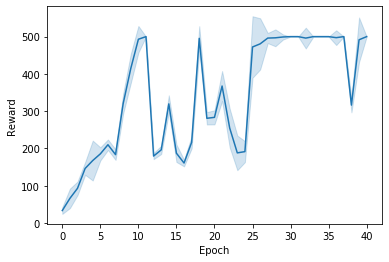

In [13]:
config['loss_name'] = ["A2C_loss","adaptative_KL_loss","clipped_loss"][0]
print("Loss : ",config["loss_name"],"\n\n")
agent = PPOAgent(config)
EPOCHS = 1000
BATCH_SIZE = 384
rewards = agent.training_batch(EPOCHS, BATCH_SIZE)